In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [162]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import plot_boxplot, plot_relative_error

from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations, get_n_updates_customized

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

set_style()

In [3]:
w_1_4 = 7 / 4
w_1_3 = 7 / 3
w_1_2 = 7 / 2
h = 1.7

s_1_4 = (w_1_4, h)
s_1_3 = (w_1_3, h)
s_1_2 = (w_1_2, h)

In [4]:
def remove_ourliers(result_df):
    q1 = result_df['normalized_error'].quantile(0.25)
    q3 = result_df['normalized_error'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    result_df_no_outliers = result_df[(result_df['normalized_error'] >= lower_bound) & (result_df['normalized_error'] <= upper_bound)].copy()
    return result_df_no_outliers

# Different Datasets

In [145]:
dataset_names = ['tpch', 'retail', 'census', 'bank']
labels = ['Ltm', 'OR', 'US', 'BM'] 

datasets_palette = {
    'tpch' : 'tab:blue',
    'retail' : 'tab:orange',
    'census' : 'tab:purple',
    'bank' : 'tab:green'
}

results = []
for dataset_name, label in zip(dataset_names, labels):
    result_df = pd.read_csv(f'../results/{dataset_name}/{dataset_name}_random.csv')
    result_df['approach'] = label
    print(f"Dataset: {dataset_name}, median normalized error: {result_df['normalized_error'].median()}")
    results.append(result_df)

Dataset: tpch, median normalized error: 0.0031261772128267
Dataset: retail, median normalized error: 4.336521445482544e-05
Dataset: census, median normalized error: 0.0009362378335429501
Dataset: bank, median normalized error: 0.000132711065891


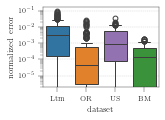

In [146]:
custom_palette = {
    'Ltm' : datasets_palette['tpch'],
    'OR' : datasets_palette['retail'],
    'US' : datasets_palette['census'],
    'BM' : datasets_palette['bank']
}

fig = plot_boxplot(results,log_scale=True, x_label='dataset', figsize=s_1_3, palette=custom_palette)

fig.savefig('../figures/datasets/normalized_error.pdf', bbox_inches='tight', dpi=300)

In [148]:
medians

[0.9504852873652136, 0.9953805050456167, 0.931539665385348, 0.9933109619686802]

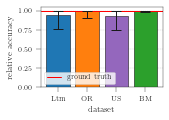

In [147]:
fig, ax = plt.subplots(figsize=s_1_3)
medians = [1 - df['relative_error'].median() for df in results]
q25 = [1 - df['relative_error'].quantile(0.25) for df in results]
q75 = [1 - df['relative_error'].quantile(0.75) for df in results]

lower_err = np.array(medians) - np.array(q75)
upper_err = np.array(q25) - np.array(medians)

ax.axhline(1, color='red', linestyle='-', label='ground truth')
ax.bar(
    range(len(labels)),
    medians,
    yerr=[lower_err, upper_err],
    color=[custom_palette[label] for label in labels],
    capsize=5,
    edgecolor='black'
)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('dataset')
ax.set_ylabel('relative accuracy')
ax.set_ylim(0.0, 1.05)
ax.legend()
ax.grid(True, axis='y', linestyle='--')

# handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.show()

# fig.savefig('../figures/datasets/relative_accuracy.pdf', bbox_inches='tight', dpi=300)


In [170]:
plot_legend(path='../figures/datasets/labels_datasets.pdf', handles=handles, labels=labels, ncol=4)

<Figure size 720x216 with 0 Axes>

In [149]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

In [151]:
rel_entropies_no_outliers

[0.004151036967321922,
 9.759677910567291e-05,
 0.005737853079450392,
 0.00013074662302143042]

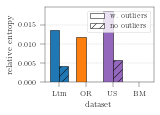

In [46]:
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=s_1_3)
rects1 = ax.bar(
    x - width/2,
    rel_entropies,
    width,
    label='w. outliers',
    color=[custom_palette[label] for label in labels],
    edgecolor='black'
)
rects2 = ax.bar(
    x + width/2,
    rel_entropies_no_outliers,
    width,
    label='no outliers',
    color=[custom_palette[label] for label in labels],
    hatch='///',
    edgecolor='black'
)

ax.set_ylabel('relative entropy')
ax.set_xlabel('dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.grid(True, axis='y', linestyle='--')

from matplotlib.patches import Patch
custom_legend = [
    Patch(facecolor='white', edgecolor='black', label='w. outliers'),
    Patch(facecolor='white', edgecolor='black', hatch='///', label='no outliers')
]
ax.legend(handles=custom_legend)

plt.tight_layout()
plt.show()

fig.savefig('../figures/datasets/relative_entropy.pdf', bbox_inches='tight', dpi=300)

## Selectivities

In [58]:
def plot_selectivities(dataset_name):
    # selectivities = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
    selectivities = np.array([0.01, 0.04, 0.16, 0.64])

    results = []
    for sel in selectivities:
        result_df = pd.read_csv(f"../results/{dataset_name}/selectivities/{dataset_name}_sel_{sel}.csv")
        result_df['approach'] = sel
        results.append(result_df)

    rel_epsilons = np.full(len(selectivities), 0.0005)
    custom_palette = {}
    for sel in selectivities:
        custom_palette[sel] = datasets_palette[dataset_name]
    return plot_boxplot(results, log_scale=True, x_label='selectivities', figsize=s_1_4, palette=custom_palette)

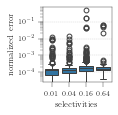

In [59]:
fig = plot_selectivities('tpch')
fig.savefig('../figures/datasets/selectivities/selectivities_tpch.pdf', bbox_inches='tight', dpi=300)

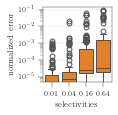

In [60]:
fig = plot_selectivities('retail')
fig.savefig('../figures/datasets/selectivities/selectivities_retail.pdf', bbox_inches='tight', dpi=300)

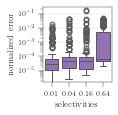

In [61]:
fig = plot_selectivities('census')
fig.savefig('../figures/datasets/selectivities/selectivities_census.pdf', bbox_inches='tight', dpi=300)

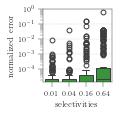

In [62]:
fig = plot_selectivities('bank')
fig.savefig('../figures/datasets/selectivities/selectivities_bank.pdf', bbox_inches='tight', dpi=300)

In [156]:
def plot_predicates(dataset_name, predicates_type:str):
    n_num_dims = {
        'tpch': 5,
        'retail': 3,
        'census': 3,
        'bank': 4
    }

    n_cat_dims = {
        'tpch': 5,
        'retail': 3,
        'census': 7,
        'bank': 6
    }

    
    if predicates_type == 'numerical':
        n_dims = np.arange(1, n_num_dims[dataset_name] + 1)
        labels = n_dims.copy()
    elif predicates_type == 'categorical':
        n_dims = np.arange(1, n_cat_dims[dataset_name] + 1)
        labels = n_dims.copy()
    elif predicates_type == 'mixed':
        dom_dims = n_cat_dims[dataset_name]
        n_dims = np.arange(1, dom_dims + 1)
        labels = n_dims.copy()
        n = 1
        for i in n_dims - 1:
            labels[i] += n
            if n < n_num_dims[dataset_name]:
                n += 1
        
    else:
        raise ValueError("predicates_type must be 'numerical', 'categorical', or 'mixed'")

    short_name = predicates_type.replace('numerical', 'num').replace('categorical', 'cat').replace('mixed', 'mix')
    
    results = []
    for i, n in enumerate(n_dims):
        result_df = pd.read_csv(f"../results/{dataset_name}/{predicates_type}/{dataset_name}_{short_name}_{n}.csv")
        result_df['approach'] = labels[i]
        print(result_df['normalized_error'].median())
        results.append(result_df)

    rel_epsilons = np.full(len(n_dims), 0.0005)

    custom_palette = {}
    for n in labels:
        custom_palette[n] = datasets_palette[dataset_name]
    return plot_boxplot(results, log_scale=True, x_label='nr. predicates', figsize=s_1_4, palette=custom_palette)

## Categorical

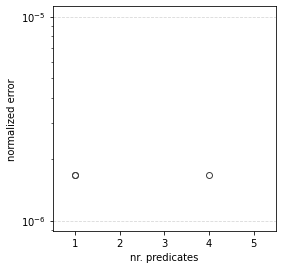

In [193]:
plot_predicates('tpch', 'categorical')

/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/visualization_utils.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


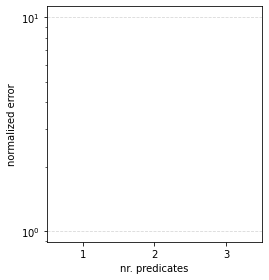

In [194]:
plot_predicates('retail', 'categorical')

5.296960868701582e-06
7.945441303052374e-06
5.296960868701582e-06
5.296960868701582e-06
3.972720651526187e-06
2.648480434350791e-06
0.0


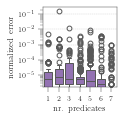

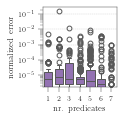

In [157]:
plot_predicates('census', 'categorical')

/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/visualization_utils.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


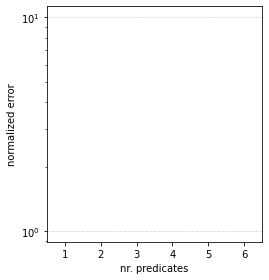

In [196]:
plot_predicates('bank', 'categorical')

## Numerical

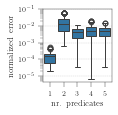

In [68]:
fig = plot_predicates('tpch', 'numerical')
fig.savefig('../figures/datasets/numerical/numerical_tpch.pdf', bbox_inches='tight', dpi=300)

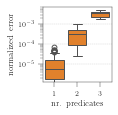

In [69]:
fig = plot_predicates('retail', 'numerical')
fig.savefig('../figures/datasets/numerical/numerical_retail.pdf', bbox_inches='tight', dpi=300)

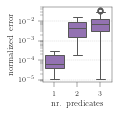

In [70]:
fig = plot_predicates('census', 'numerical')
fig.savefig('../figures/datasets/numerical/numerical_census.pdf', bbox_inches='tight', dpi=300)

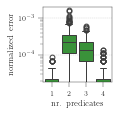

In [71]:
fig = plot_predicates('bank', 'numerical')
fig.savefig('../figures/datasets/numerical/numerical_bank.pdf', bbox_inches='tight', dpi=300)

## Mixed

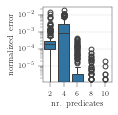

In [64]:
fig = plot_predicates('tpch', 'mixed')
fig.savefig('../figures/datasets/mixed/mixed_tpch.pdf', bbox_inches='tight', dpi=300)

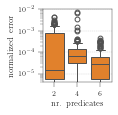

In [65]:
fig = plot_predicates('retail', 'mixed')
fig.savefig('../figures/datasets/mixed/mixed_retail.pdf', bbox_inches='tight', dpi=300)

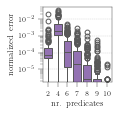

In [66]:
fig = plot_predicates('census', 'mixed')
fig.savefig('../figures/datasets/mixed/mixed_census.pdf', bbox_inches='tight', dpi=300)

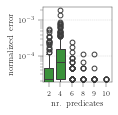

In [67]:
fig = plot_predicates('bank', 'mixed')
fig.savefig('../figures/datasets/mixed/mixed_bank.pdf', bbox_inches='tight', dpi=300)

## Update Throughput

In [130]:
levels = 5
ad_tree_levels = 5
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

n_cat_retail = 3
n_num_retail = 3
cat_updates_retail, num_updates_retail, region_updates_retail = get_n_updates(n_cat_retail, n_num_retail, levels)

ad_tree_levels = 6
num_combinations = 11
cat_updates_bank, num_updates_bank, region_updates_bank = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

cat_col_map_census = [0, 1, 2, 3, 4, 5, 6]
num_col_map_census = [7, 8, 9]
bases_census = [2, 10, 2]

n_cat_census = len(cat_col_map_census)
n_num_census = len(num_col_map_census)

ad_tree_levels = len(cat_col_map_census)
num_combinations = 2**len(num_col_map_census) - 1

cat_updates_census, num_updates_census, region_updates_census = get_n_updates_customized(ad_tree_levels, num_combinations, levels)


In [131]:
bloom_p = 0.01
bank_df = pd.read_parquet("../data/clean/bank_marketing.parquet")
len_df = len(bank_df)
print(f"Bank dataset length: {len_df}")
_, k_bank_num = BFParameters(n_values=len_df * num_updates_bank, p=bloom_p).peek_size()
_, k_bank_reg = BFParameters(n_values=len_df * region_updates_bank, p=bloom_p).peek_size()

retail_df = pd.read_parquet("../data/clean/online_retail.parquet")
len_df = len(retail_df)
print(f"Retail dataset length: {len_df}")
_, k_retail_num = BFParameters(n_values=len_df * num_updates_retail, p=bloom_p).peek_size()
_, k_retail_reg = BFParameters(n_values=len_df * region_updates_retail, p=bloom_p).peek_size()

census_df = pd.read_parquet("../data/clean/acs_folktables.parquet")
len_df = len(census_df)
print(f"Census dataset length: {len_df}")
_, k_census_cat = BFParameters(n_values=len_df * cat_updates_census, p=bloom_p).peek_size()
_, k_census_num = BFParameters(n_values=len_df * num_updates_census, p=bloom_p).peek_size()
_, k_census_reg = BFParameters(n_values=len_df * region_updates_census, p=bloom_p).peek_size()

lineitem_df = pd.read_parquet("../data/tpch/lineitem_0.1.parquet")
len_df = len(lineitem_df)
print(f"TPCH dataset length: {len_df}")
_, k_tpch_num = BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_size()
_, k_tpch_reg = BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_size()

Bank dataset length: 45211
Retail dataset length: 541909
Census dataset length: 377575
TPCH dataset length: 599934


In [132]:
throughputs = np.asarray([780,1685,1108,1018])
total_updates_tpch = cat_updates_tpch + num_updates_tpch * k_tpch_num + region_updates_tpch * k_tpch_reg + region_updates_tpch * 5
total_updates_retail = cat_updates_retail + num_updates_retail * k_retail_num + region_updates_retail * k_retail_reg + region_updates_retail * 5
total_updates_census = cat_updates_census * k_census_cat + num_updates_census * k_census_num + region_updates_census * k_census_reg + region_updates_census * 5
total_updates_bank = cat_updates_bank + num_updates_bank * k_bank_num + region_updates_bank * k_bank_reg + region_updates_bank * 5

total_updates = np.array([total_updates_tpch, total_updates_retail, total_updates_census, total_updates_bank])
dataset_names = ['tpch', 'retail', 'census', 'bank']
labels = ['Lineitem', 'Onl. Retail', 'US census', 'Bank Mktg.'] 
custom_palette = {
    'Lineitem' : datasets_palette['tpch'],
    'Onl. Retail' : datasets_palette['retail'],
    'US census' : datasets_palette['census'],
    'Bank Mktg.' : datasets_palette['bank']
}

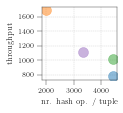

In [135]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X = total_updates.reshape(-1, 1)
y = throughputs

# Fit linear regression
# reg = LinearRegression().fit(X, y)
# y_pred = reg.predict(X)

fig, ax = plt.subplots(figsize=(w_1_4, 1.6))

for i, label in enumerate(labels):
    ax.scatter(total_updates[i], throughputs[i], alpha=0.5, color=custom_palette[label], label=label, s=100)


# Plot regression line
# ax.plot(total_updates, y_pred, color='black', linestyle='--', label='Linear fit')

ax.set_ylabel('throughput')
ax.set_xlabel('nr. hash op. / tuple')
# ax.legend()
ax.grid(True, linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()

plt.tight_layout()
plt.show()

fig.savefig('../figures/datasets/update_throughput.pdf', bbox_inches='tight', dpi=300)

In [51]:
plot_legend(path='../figures/datasets/labels_scatter.pdf', handles=handles, labels=labels, ncol=4)

<Figure size 720x216 with 0 Axes>

## Update single 

In [136]:
levels = 5
ad_tree_levels = 5
num_combinations = 1
cat_updates_tpch_single, num_updates_tpch_single, region_updates_tpch_single = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

ad_tree_levels = 4
num_combinations = 1
cat_updates_retail_single, num_updates_retail_single, region_updates_retail_single = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

ad_tree_levels = 6
num_combinations = 1
cat_updates_bank_single, num_updates_bank_single, region_updates_bank_single = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

cat_col_map_census = [0, 1, 2, 3, 4, 5, 6]
num_col_map_census = [7, 8, 9]
bases_census = [2, 10, 2]

n_cat_census = len(cat_col_map_census)
n_num_census = len(num_col_map_census)

ad_tree_levels = len(cat_col_map_census)
num_combinations = 1
cat_updates_census_single, num_updates_census_single, region_updates_census_single = get_n_updates_customized(ad_tree_levels, num_combinations, levels)


In [137]:
throughputs = np.asarray([2516,3426,2058,2130])
total_updates_tpch = cat_updates_tpch + num_updates_tpch_single * k_tpch_num + region_updates_tpch_single * k_tpch_reg + region_updates_tpch_single * 5
total_updates_retail = cat_updates_retail + num_updates_retail_single * k_retail_num + region_updates_retail_single * k_retail_reg + region_updates_retail_single * 5
total_updates_census = cat_updates_census * k_census_cat + num_updates_census_single * k_census_num + region_updates_census_single * k_census_reg + region_updates_census_single * 5
total_updates_bank = cat_updates_bank + num_updates_bank * k_bank_num + region_updates_bank_single * k_bank_reg + region_updates_bank_single * 5

total_updates = np.array([total_updates_tpch, total_updates_retail, total_updates_census, total_updates_bank])
dataset_names = ['tpch', 'retail', 'census', 'bank']
labels = ['Lineitem', 'Onl. Retail', 'US census', 'Bank Mktg.'] 
custom_palette = {
    'Lineitem' : datasets_palette['tpch'],
    'Onl. Retail' : datasets_palette['retail'],
    'US census' : datasets_palette['census'],
    'Bank Mktg.' : datasets_palette['bank']
}

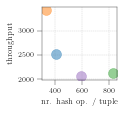

In [138]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X = total_updates.reshape(-1, 1)
y = throughputs

# Fit linear regression
# reg = LinearRegression().fit(X, y)
# y_pred = reg.predict(X)

fig, ax = plt.subplots(figsize=(w_1_4, 1.6))

for i, label in enumerate(labels):
    ax.scatter(total_updates[i], throughputs[i], alpha=0.5, color=custom_palette[label], label=label, s=100)


# Plot regression line
# ax.plot(total_updates, y_pred, color='black', linestyle='--', label='Linear fit')

ax.set_ylabel('throughput')
ax.set_xlabel('nr. hash op. / tuple')
# ax.legend()
ax.grid(True, linestyle='--')

# handles, labels = plt.gca().get_legend_handles_labels()

plt.tight_layout()
plt.show()

fig.savefig('../figures/datasets/update_throughput_single.pdf', bbox_inches='tight', dpi=300)

## Error Details

In [139]:
results = []
for dataset_name, label in zip(dataset_names, labels):
    result_df = pd.read_csv(f'../results/{dataset_name}/{dataset_name}_random.csv')
    result_df['approach'] = label
    results.append(result_df)

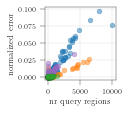

In [140]:
fig, ax = plt.subplots(figsize=(w_1_4, 1.6))

for df in results:
    label = df['approach'].iloc[0]
    ax.scatter(
        df['query_regions'],
        df['normalized_error'],
        alpha=0.5,
        label=label,
        color=custom_palette[label]
    )

ax.set_xlabel('nr query regions')
ax.set_ylabel('normalized error')
# ax.legend()
ax.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

fig.savefig('../figures/datasets/error_query_regions.pdf', bbox_inches='tight', dpi=300)

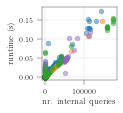

In [141]:
fig, ax = plt.subplots(figsize=(w_1_4, 1.6))

for df in results:
    label = df['approach'].iloc[0]
    df = df[df['total_sketch_queries'] < 200_000]  
    ax.scatter(
        df['total_sketch_queries'],
        df['runtimes'],
        alpha=0.5,
        label=label,
        color=custom_palette[label]
    )

ax.set_xlabel('nr. internal queries')
ax.set_ylabel('runtime (s)')
# ax.legend()
ax.grid(True, linestyle='--')
plt.tight_layout()
plt.show()
fig.savefig('../figures/datasets/query_runtime.pdf', bbox_inches='tight', dpi=300)

# Lineitem Scale

In [158]:
ad_tree_levels = 5
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, 5)

In [159]:
scale_factors = 4**np.arange(5) * 0.03125
n_elements = ['187 k', '750 k', '3 M', '12 M', '48 M']

results = []
for sf, n in zip(scale_factors, n_elements):
    result_df = pd.read_csv(f"../results/tpch/scale/tpch_random_results_2_{sf}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/scale/tpch_random_results_{sf}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df = result_df[result_df['b_adic_cubes'] < 50_000]
    result_df['approach'] = n
    results.append(result_df)

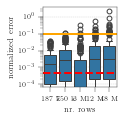

In [160]:
labels = n_elements
custom_palette = {}
for label in labels:
    custom_palette[label] = 'tab:blue'
fig = plot_boxplot(results, target=0.0005, log_scale=True, x_label='~ nr. rows', figsize=s_1_4, palette=custom_palette)

fig.savefig('../figures/scale/scale_tpch.pdf', bbox_inches='tight', dpi=300)

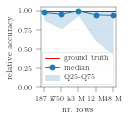

In [163]:
fig = plot_relative_error(results, labels=n_elements, figsize=s_1_4, 
                    x_label='~ nr. rows') 

fig.savefig('../figures/scale/scale_relative_error_tpch.pdf', bbox_inches='tight', dpi=300)

In [165]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

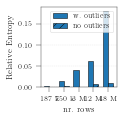

In [166]:
labels = n_elements
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=s_1_4)
rects1 = ax.bar(x - width/2, rel_entropies, width, color=datasets_palette['tpch'], label='w. outliers', edgecolor='black')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width,  color=datasets_palette['tpch'],label='no outliers', hatch='///',
    edgecolor='black')

ax.set_ylabel('Relative Entropy')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
# ax.set_title('Relative Entropy Comparison')

plt.tight_layout()
plt.show()

fig.savefig('../figures/scale/scale_relative_entropy_tpch.pdf', bbox_inches='tight', dpi=300)

In [167]:
rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

error_eps = rel_eps / region_updates_tpch
sizes = []
for len_df in (4**np.arange(5) * 187500):
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

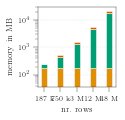

In [169]:
fig, ax = plt.subplots(figsize=s_1_4)
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

custom_palette = {
    'BloomFilter (num)': 'tab:cyan',
    'BloomFilter (region)': 'tab:olive',
    'CountMinSketch': 'tab:gray',
    'CountMinSketch/level': 'tab:pink'
}
x = np.arange(len(sizes))
for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(n_elements)
handles, legend_labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], legend_labels[::-1])
plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
# plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

# Sketch Size

In [83]:
probs = 2**np.arange(7)*0.005
rel_epsilons = 2**np.arange(7) * 0.00025

# labels = [f'p={p}\nε={eps}' for p, eps in zip(probs, rel_epsilons)]
labels = np.arange(1, len(probs) +1)


results = []
for label, p, eps in zip(labels, probs, rel_epsilons):
    result_df = pd.read_csv(f"../results/tpch/size/tpch_random_results_0.1_eps_{eps}_p_{p}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/size/tpch_random_results_2_0.1_eps_{eps}_p_{p}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df['approach'] = label
    results.append(result_df)

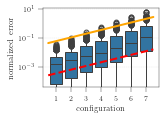

In [202]:
custom_palette = {}
for label in labels:
    custom_palette[label] = 'tab:blue'
fig = plot_boxplot(results, log_scale=True, rotation=0, target=rel_epsilons, x_label='configuration', figsize=s_1_3, palette=custom_palette)
fig.savefig('../figures/size/error_tpch_size.pdf', bbox_inches='tight', dpi=300)

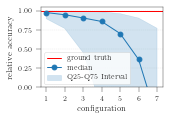

In [86]:
fig = plot_relative_error(results, labels=labels, figsize=s_1_3, 
                    x_label='configuration') 

fig.savefig('../figures/size/size_relative_error_tpch.pdf', bbox_inches='tight', dpi=300)

In [203]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

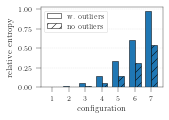

In [220]:
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=s_1_3)
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers',color=[datasets_palette['tpch']]*len(rel_entropies), edgecolor='black')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width,color=[datasets_palette['tpch']]*len(rel_entropies), label='No Outliers', hatch='///',
    edgecolor='black' )

ax.set_ylabel('relative entropy')
ax.set_xlabel('configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# custom_legend = [
#     Patch(facecolor='white', edgecolor='black', label='w. outliers'),
#     Patch(facecolor='white', edgecolor='black', hatch='///', label='no outliers')
# ]
ax.legend(handles=custom_legend)
# ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
# ax.set_title('Relative Entropy Comparison')
# plt.xticks(rotation=-70, ha='center')

plt.tight_layout()
plt.show()

fig.savefig('../figures/size/relative_entropy_tpch_size.pdf', bbox_inches='tight', dpi=300)

In [87]:
rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

lineitem_df = pd.read_parquet("../data/tpch/lineitem_0.1.parquet")
len_df = len(lineitem_df)
sizes = []
for label, bloom_p, rel_eps in zip(labels, probs, rel_epsilons):
    error_eps = rel_eps / region_updates_tpch
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

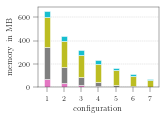

In [88]:
fig, ax = plt.subplots(figsize=s_1_3)
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

x = np.arange(len(labels))

custom_palette = {
    'BloomFilter (num)': 'tab:cyan',
    'BloomFilter (region)': 'tab:olive',
    'CountMinSketch': 'tab:gray',
    'CountMinSketch/level': 'tab:pink'
}
x = np.arange(len(sizes))
for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, color=custom_palette[labels_stack[i]], label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.grid(True, axis='y', linestyle='--')
# handles, legend_labels = ax.get_legend_handles_labels()
handles, labels = plt.gca().get_legend_handles_labels()
# ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
# plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

fig.savefig('../figures/size/size_tpch.pdf', bbox_inches='tight', dpi=300)

In [90]:
plot_legend(path='../figures/size/labels_sizes_2.pdf', handles=handles, labels=labels, ncol=2)

<Figure size 720x216 with 0 Axes>

# Query Time

In [91]:
custom_palette = {
    64 : 'tab:brown',
    128 : 'tab:purple',
    256 : 'tab:pink',
    512 : 'tab:green',
    1024 : 'tab:orange',
    2048 : 'tab:blue'
    }

In [92]:
max_idx = 10
times_pd_1024 = np.empty(max_idx)
times_pd_2048 = np.empty(max_idx)
times_512 = np.empty(max_idx)
times_1024 = np.empty(max_idx)
times_2048 = np.empty(max_idx)

for n in np.arange(max_idx):
    result_512 = pd.read_csv(f"../results/tpch/fix_size/tpch_fix_512_MB_{n}.csv")
    result_1024 = pd.read_csv(f"../results/tpch/fix_size/tpch_fix_1024_MB_{n}.csv")
    result_2048 = pd.read_csv(f"../results/tpch/fix_size/tpch_fix_2048_MB_{n}.csv")
    
    times_pd_1024[n] = result_1024['baseline_runtimes'].mean()
    times_pd_2048[n] = result_2048['baseline_runtimes'].mean()
    times_512[n] = result_512['runtimes'].mean()
    times_1024[n] = result_1024['runtimes'].mean()
    times_2048[n] = result_2048['runtimes'].mean()


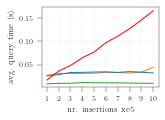

In [93]:

x = np.arange(1, max_idx + 1)
plt.figure(figsize=s_1_3)
plt.plot(x, times_512, label='Pacha Sketch 512MB', color=custom_palette[512])
plt.plot(x, times_1024, label='Pacha Sketch 1024MB', color=custom_palette[1024])
plt.plot(x, times_2048, label='Pacha Sketch 2048MB', color=custom_palette[2048])
plt.plot(x, times_pd_1024, label='Pandas', color='red')
# plt.plot(x, times_pd_2048, label='Pandas 2048MB', color='tab:red')

plt.xlabel('nr. insertions xe5')
plt.ylabel('avg. query time (s)')
plt.xticks(x)  # Ensure x-ticks start at 1
handles, labels = plt.gca().get_legend_handles_labels()

# plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../figures/fix_size/fix_size_query_time.pdf', bbox_inches='tight', dpi=300)
plt.show()



# plt.savefig('../figures/fix_size/fix_size_query_time.pdf', bbox_inches='tight', dpi=300)


# Fix Size (Streaming)

In [94]:
mem_budgets = (2**np.arange(6) * 64).astype(int)  
max_n = 0

column_to_use = 'normalized_error'
# column_to_use = 'relative_error'

results_medians = {}
results_25 = {}
results_75 = {}
not_valids = {}
for mem_budget in mem_budgets:
    medians = []
    quantiles_25 = []
    quantiles_75 = []
    not_valid = []
    for n in np.arange(170):
        try:                            
            result_df = pd.read_csv(f"../results/tpch/fix_size/tpch_fix_{mem_budget}_MB_{n}.csv")
        except FileNotFoundError:
            print(f"File not found for mem budget: {mem_budget}, n: {n}")
            # print(f"../results/tpch/fix_size/tpch_fix_{mem_budget}_{n}.csv")
            break
        result_df = result_df[result_df['b_adic_cubes'] < 50_000]
        if result_df.empty:
            print('No valid results for mem budget:', mem_budget, 'and n:', n)
            break
        med = result_df[column_to_use].median()
        if med < 0.0 or med > 1.0:
            not_valid.append(n)
        medians.append(result_df[column_to_use].median())
        quantiles_25.append(result_df[column_to_use].quantile(0.25))
        quantiles_75.append(result_df[column_to_use].quantile(0.75))
        max_n = max(max_n, n)
    results_medians[mem_budget] = np.asarray(medians)
    results_25[mem_budget] = np.asarray(quantiles_25)
    results_75[mem_budget] = np.asarray(quantiles_75)
    not_valids[mem_budget] = not_valid


File not found for mem budget: 64, n: 3
File not found for mem budget: 128, n: 3
File not found for mem budget: 256, n: 5
File not found for mem budget: 512, n: 27


In [123]:
len_512 = len(results_medians[512])
len_1024 = len(results_medians[1024])

len_diff = len_1024 - len_512

diff_median = results_medians[512] - results_medians[1024][:len_512]
tail_median_512 = np.full(len_diff, diff_median[-1]) + results_medians[1024][len_512:]

tail_25_512 = np.full(len_diff, results_25[512][-1])

diff_75 = results_75[512] - results_75[1024][:len_512]
tail_75_512 = np.full(len_diff, diff_75[-1]) + results_75[1024][len_512:]


results_medians[512] = np.concatenate((results_medians[512], tail_median_512))
results_25[512] = np.concatenate((results_25[512], tail_25_512))
results_75[512] = np.concatenate((results_75[512], tail_75_512))

In [115]:
len_diff

143

In [117]:
len(np.full(len_diff, diff[-1]) * results_medians[1024][len_512:])

143

In [ ]:
np.full(len_diff, diff[-1])

In [108]:

def plot_variable_length_error_lines(
    results_medians,
    results_25,
    results_75,
    figsize=(6, 4),
    min_mem=None,  
    index_range=None  # e.g., (1, 4)
):
    # Prepare the figure
    fig = plt.figure(figsize=figsize)
    # plt.plot(times_pd_1024, label='Pandas', color='red')
    for method in results_medians:
        if min_mem is not None and method < min_mem:
            continue
        y_median = results_medians[method]
        y25 = results_25[method]
        y75 = results_75[method]

        # Compute range
        start, end = index_range if index_range else (0, len(y_median))
        x = np.arange(1, len(y_median)+1, dtype=int)[start:end]

        plt.plot(x, y_median[start:end], label=f"{method} MB", color=custom_palette[method])
        plt.fill_between(x, y25[start:end], y75[start:end], color=custom_palette[method], alpha=0.2)

    if index_range:
        plt.xticks(np.arange(index_range[0]+1, index_range[1]+2, (index_range[1]-index_range[0])//5))
    else:
        n_points = len(y_median)
        plt.xticks(np.linspace(1, n_points, 10, dtype=int))
    plt.xlabel('nr. insertions xe5')
    plt.ylabel('normalized error')
    plt.grid(True, linestyle='--', alpha=0.5)
    handles, labels = plt.gca().get_legend_handles_labels()
    # plt.legend()
    plt.tight_layout()
    plt.show()

    return fig


In [107]:
def plot_variable_length_accuracy(
    results_medians,
    results_25,
    results_75,
    figsize=(6, 4),
    min_mem=None,  
    index_range=None  # e.g., (1, 4)
):
    
    fig, ax = plt.subplots(figsize=figsize)
    # ax.axhline(1, color='red', linestyle='-', label='ground truth')
    for method in results_medians:
        if min_mem is not None and method < min_mem:
            continue
        medians = 1 - results_medians[method]
        q25 = 1 - results_25[method]
        q75 = 1 - results_75[method]
        start, end = index_range if index_range else (0, len(medians))
        x = np.arange(len(medians), dtype=int)[start:end]
        ax.plot(x, medians[start:end], color=custom_palette[method], label='median')
        ax.fill_between(x, q25[start:end], q75[start:end], color=custom_palette[method], alpha=0.2, label='Q25-Q75 Interval')
    
    # ax.set_xticks(range(len(labels)))
    # ax.set_xticklabels(labels)
    plt.xlabel('nr. insertions xe5')
    ax.set_ylabel('relative accuracy')
    handles, labels = plt.gca().get_legend_handles_labels()

    ax.set_ylim(0.0, 1.05)
    # ax.legend()
    plt.grid(True, axis='y', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

    return fig

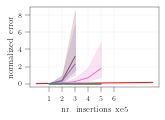

In [105]:
handles, labels = plot_variable_length_error_lines(results_medians, results_25, results_75, figsize=s_1_3, index_range=(0, 5))


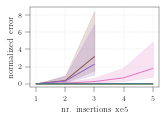

In [100]:
fig = plot_variable_length_error_lines(results_medians, results_25, results_75, figsize=s_1_3, index_range=(0, 5))
fig.savefig('../figures/fix_size/error_fix_size_5.pdf', bbox_inches='tight', dpi=300)

In [106]:
plot_legend(path='../figures/fix_size/labels_fix_size.pdf', handles=handles, labels=labels, ncol=7)

<Figure size 720x216 with 0 Axes>

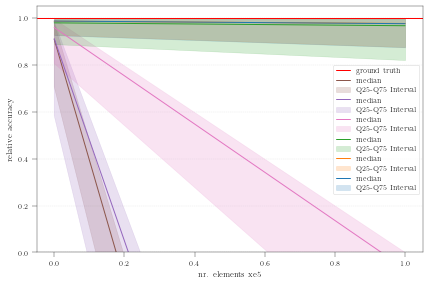

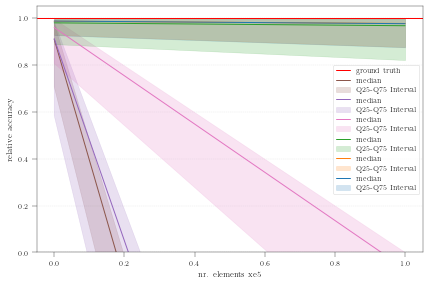

In [270]:
plot_variable_length_accuracy(results_medians, results_25, results_75, index_range=(0, 2))

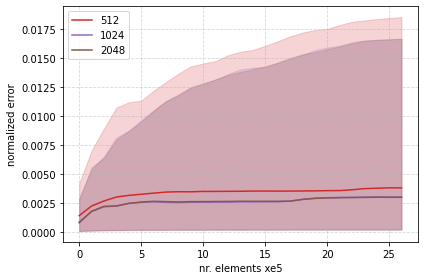

In [65]:
plot_variable_length_error_lines(results_medians, results_25, results_75, index_range=(0, 27), min_mem=512)

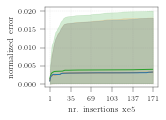

In [125]:
fig = plot_variable_length_error_lines(results_medians, results_25, results_75, figsize=s_1_3, index_range=(0,170), min_mem=512)
fig.savefig('../figures/fix_size/error_fix_size_175.pdf', bbox_inches='tight', dpi=300)

In [57]:
    
for mem_budget in 2**np.arange(6) * 64:
    print(f"Memory budget: {mem_budget} MB")
    levels = 5

    cat_col_map_tpch = [0, 1, 2, 3, 4]
    n_cat_tpch = len(cat_col_map_tpch)
    num_col_map_tpch = [5, 6, 7, 8, 9]
    n_num_tpch = len(num_col_map_tpch)
    bases_tpch = [5,5,5,10,2]

    ad_tree_levels = len(cat_col_map_tpch)
    num_combinations = 13
    cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

    mem_cms = mem_budget / 2
    
    rel_eps = 0.0005
    delta = 0.01
    error_eps = rel_eps / region_updates_tpch

    mem_cms = mem_budget * 0.25 / levels
    n_counters = mem_cms * 1024 * 1024 / 4
    depth = 3
    width = n_counters // depth
    error_eps = np.e/width
    while error_eps < rel_eps / region_updates_tpch and depth < 5:
        depth += 1
        width = n_counters // depth
        error_eps = np.e/width
    
    if error_eps < rel_eps / region_updates_tpch:
        error_eps = rel_eps / region_updates_tpch
        cms_params = CMParameters(delta=delta, error_eps=error_eps)
    else:
        cms_params = CMParameters(width=int(width), depth=int(depth))

    mem_cms = cms_params.peek_memory() * levels
   
    print(f"Memory for CMSs: {mem_cms} MB")
    mem_index = mem_budget - mem_cms
    p_num_index = num_updates_tpch / (num_updates_tpch + region_updates_tpch)
    p_region_index = 1.0 - p_num_index

    mem_num_index = mem_index * p_num_index
    print(f"Memory for num index: {mem_num_index} MB")
    mem_region_index = mem_index * p_region_index
    print(f"Memory for region index: {mem_region_index} MB")

Memory budget: 64 MB
Memory for CMSs: 15.999984741210938 MB
Memory for num index: 8.00000254313151 MB
Memory for region index: 40.000012715657554 MB
Memory budget: 128 MB
Memory for CMSs: 31.999969482421875 MB
Memory for num index: 16.00000508626302 MB
Memory for region index: 80.00002543131511 MB
Memory budget: 256 MB
Memory for CMSs: 63.999996185302734 MB
Memory for num index: 32.000000635782875 MB
Memory for region index: 160.0000031789144 MB
Memory budget: 512 MB
Memory for CMSs: 127.99995422363281 MB
Memory for num index: 64.00000762939453 MB
Memory for region index: 320.00003814697266 MB
Memory budget: 1024 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 142.1507396697998 MB
Memory for region index: 710.753698348999 MB
Memory budget: 2048 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 312.81740633646643 MB
Memory for region index: 1564.0870316823325 MB


# Extra

Total memory budget: 64.0 MB
Memory budget: 40 MB


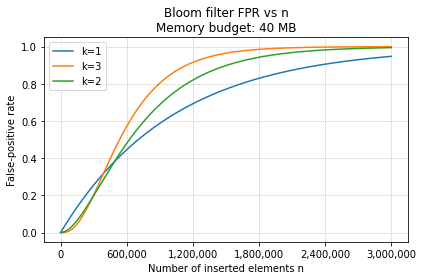

Total memory budget: 128.0 MB
Memory budget: 80 MB


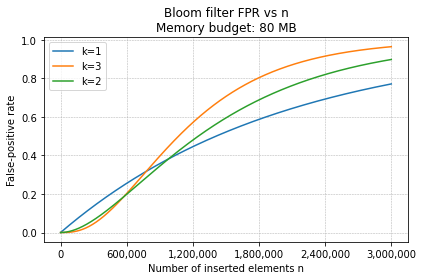

Total memory budget: 256.0 MB
Memory budget: 160 MB


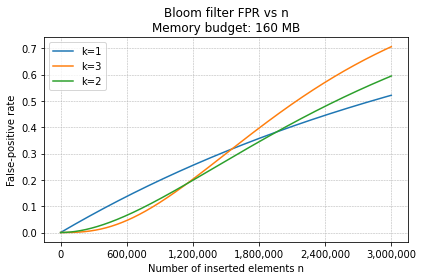

Total memory budget: 512.0 MB
Memory budget: 320 MB


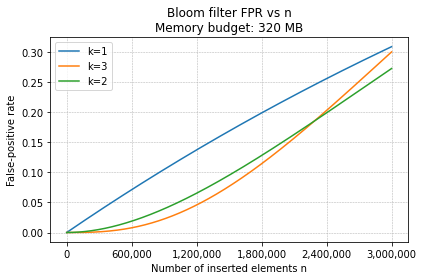

Total memory budget: 1024.0 MB
Memory budget: 640 MB


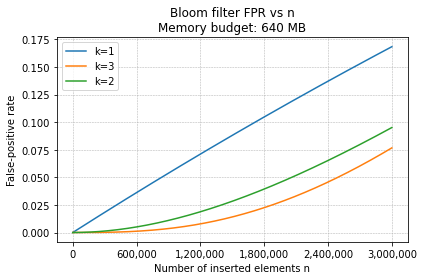

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper functions --------------------------------------------------------

def optimal_k(m_bits: int, n_items: int) -> float:
    """
    Optimal number of hash functions for a classic Bloom filter
    given bit‑array size m (in bits) and expected element count n.
    
    k = (m / n) * ln 2
    """
    from math import log
    return (m_bits / n_items) * log(2)

def false_positive_rate(m_bits: int, k: int, n_items: np.ndarray) -> np.ndarray:
    """
    Vectorised computation of Bloom filter false‑positive rate:
    
        f(n) = (1 - exp(-k * n / m)) ** k
    """
    return (1 - np.exp(-k * n_items / m_bits)) ** k

# --- Parameters you can tweak -----------------------------------------------

mem_budgets = 2**np.arange(5) * 64.0
for m_bits in mem_budgets:
    print(f"Total memory budget: {m_bits} MB")
    m_bits = m_bits * 0.75 * (region_updates_tpch / (region_updates_tpch + num_updates_tpch))
    print(f"Memory budget: {m_bits:.0f} MB")
    m_bits = int(m_bits * 8 * 1024 * 1024)  
    # n_elements = 48_000_000
    n_elements = 3_000_000
    n_updates = region_updates_tpch * n_elements
    n_values = np.linspace(1, n_updates, 1000)
    k_opt = int(optimal_k(m_bits, (n_updates // 2)))
    # if k_opt < 1:
    k_opt = 3
    k_low = 1
    k_high = 2

    fp_values_low = false_positive_rate(m_bits, k_low, n_values)
    fp_values_opt = false_positive_rate(m_bits, k_opt, n_values)
    fp_values_high = false_positive_rate(m_bits, k_high, n_values)


    
    plt.figure(figsize=(6, 4))
    plt.plot(n_values, fp_values_low, label=f'k={k_low}')
    plt.plot(n_values, fp_values_opt, label=f'k={k_opt}')
    plt.plot(n_values, fp_values_high, label=f'k={k_high}')
    plt.xlabel("Number of inserted elements n")
    plt.ylabel("False‑positive rate")
    plt.title(f"Bloom filter FPR vs n\nMemory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    plt.xticks(
        ticks=np.linspace(n_values[0], n_values[-1], 6),
        labels=[f"{int(val/region_updates_tpch):,}" for val in np.linspace(n_values[0], n_values[-1], 6)]
    )
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [217]:
m_bits = 100*8*1024*1024
n_star = m_bits / 3 * np.log(2)
false_positive_rate(m_bits, 3, n_star/2)

0.02512626584708365

In [218]:
n_star/2/region_updates_tpch

293663.6355566971

In [199]:
error_eps = rel_eps / region_updates_tpch
CMParameters(delta=delta, error_eps=error_eps).peek_size()

(56065, 5)

In [209]:
rel_eps = 0.0005
levels = 5
delta = 0.01
error_eps = rel_eps / region_updates_tpch
print(CMParameters(delta=delta, error_eps=error_eps).peek_size())
print(CMParameters(delta=delta, error_eps=error_eps).peek_memory())

(1794067, 5)
34.219112396240234


In [211]:
rel_eps / region_updates_tpch

1.5151515151515152e-06

In [213]:
levels = 5
mem_budgets = 2**np.arange(6) * 64
for mem_budget in mem_budgets:
    mem_cms = mem_budget / 2 / levels
    n_counters = mem_cms * 1024 * 1024 / 4
    depth = 3
    width = n_counters // depth
    error_eps = np.e/width
    while error_eps < rel_eps / region_updates_tpch and depth < 5:
        depth += 1
        width = n_counters // depth
        error_eps = np.e/width
    
    if error_eps < rel_eps / region_updates_tpch:
        error_eps = rel_eps / region_updates_tpch
        cms_params = CMParameters(delta=delta, error_eps=error_eps)
    else:
        cms_params = CMParameters(width=width, depth=depth)
    
    print(f"Memory budget: {mem_budget} MB, Width: {cms_params.width}, Depth: {cms_params.depth}, Error epsilon: {error_eps}")
    print(cms_params.peek_memory())

Memory budget: 64 MB, Width: 559240.0, Depth: 3, Error epsilon: 4.860671319038419e-06
6.399993896484375
Memory budget: 128 MB, Width: 1118481.0, Depth: 3, Error epsilon: 2.4303334866296745e-06
12.799999237060547
Memory budget: 256 MB, Width: 1677721.0, Depth: 4, Error epsilon: 1.6202228072838363e-06
25.599990844726562
Memory budget: 512 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234
Memory budget: 1024 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234
Memory budget: 2048 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234


In [197]:
2**np.arange(6) * 64

array([  64,  128,  256,  512, 1024, 2048])

In [192]:
mem_budgets = 2**np.arange(6) * 64.0 * 8 * 1024 * 1024
for m_bits in mem_budgets:
    p_num_index = num_updates_tpch / (num_updates_tpch + region_updates_tpch)
    p_region_index = 1.0 - p_num_index

    n_bits_num_index = int(np.ceil(m_bits * p_num_index))
    n_bits_region_index = int(np.ceil(m_bits * p_region_index))

    n_star_num = n_bits_num_index / 3 * np.log(2)
    n_star_region = n_bits_region_index / 3 * np.log(2)
    print(f"Memory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    print(f"Number of elements for num index: {n_star_num/num_updates_tpch:,.0f}")
    print(f"Number of elements for region index: {n_star_region/region_updates_tpch:,.0f}\n")


Memory budget: 64 MB
Number of elements for num index: 313,241
Number of elements for region index: 313,241

Memory budget: 128 MB
Number of elements for num index: 626,482
Number of elements for region index: 626,482

Memory budget: 256 MB
Number of elements for num index: 1,252,965
Number of elements for region index: 1,252,965

Memory budget: 512 MB
Number of elements for num index: 2,505,930
Number of elements for region index: 2,505,930

Memory budget: 1024 MB
Number of elements for num index: 5,011,859
Number of elements for region index: 5,011,859

Memory budget: 2048 MB
Number of elements for num index: 10,023,719
Number of elements for region index: 10,023,719



In [ ]:
mem_budgets = np.arange(10)

In [169]:
CMParameters(delta=delta, error_eps=error_eps).peek_memory() * levels

5.346775054931641

In [187]:
df_path = f"../data/tpch/lineitem_8.parquet"
lineitem_df = pd.read_parquet(df_path)

In [188]:
len(lineitem_df)

47989007

In [214]:
chunks = np.array_split(lineitem_df, 240)

/home/rudi/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
import math
import itertools
import mmh3

class CountMinSketch:
    """
    Simple Count-Min Sketch implementation.
    """
    def __init__(self, width, depth, seed=0):
        self.width = width
        self.depth = depth
        self.seed = seed
        self.table = [[0] * width for _ in range(depth)]
        self.hash_seeds = [seed + i * 17 for i in range(depth)]

    def update(self, key, count=1):
        for i, hs in enumerate(self.hash_seeds):
            idx = mmh3.hash(str(key), hs) % self.width
            self.table[i][idx] += count

    def estimate(self, key):
        min_count = math.inf
        for i, hs in enumerate(self.hash_seeds):
            idx = mmh3.hash(str(key), hs) % self.width
            min_count = min(min_count, self.table[i][idx])
        return min_count

class OmniSketch:
    """
    OmniSketch for multidimensional count queries via canonical decomposition.

    Supports d-dimensional data by maintaining a Count-Min Sketch for each
    subset of dimensions (power set). Queries are answered via inclusion-exclusion.
    """
    def __init__(self, dims, width=1000, depth=5, seed=0):
        """
        dims: list of dimension names or indices
        width, depth: parameters for each internal CMS
        """
        self.dims = dims
        self.d = len(dims)
        # create CMS for each non-empty subset of dims
        self.sketches = {}
        for r in range(1, self.d + 1):
            for subset in itertools.combinations(self.dims, r):
                self.sketches[subset] = CountMinSketch(width, depth, seed)

    def _tuple_key(self, record, subset):
        """
        Extracts the tuple of values for the given subset from the record.
        """
        return tuple(record[dim] for dim in subset)

    def update(self, record, count=1):
        """
        Update all sketches with the record count.
        record: dict mapping dims to values
        """
        for subset, sketch in self.sketches.items():
            key = self._tuple_key(record, subset)
            sketch.update(key, count)

    def query(self, predicate):
        """
        Estimate count for a conjunction predicate: dict of dim->value.

        Uses inclusion-exclusion principle over all subsets of the predicate dims.
        predicate: dict mapping some dims to values
        """
        # list of (dim, value) pairs in predicate
        items = list(predicate.items())
        total = 0
        # iterate all non-empty subsets
        for r in range(1, len(items) + 1):
            for comb in itertools.combinations(items, r):
                dims_subset, vals = zip(*comb)
                # sign for inclusion-exclusion
                sign = -1 if (r % 2 == 0) else 1
                key = tuple(vals)
                est = self.sketches[tuple(dims_subset)].estimate(key)
                total += sign * est
        return total

# Example usage:
if __name__ == "__main__":
    dims = ['A', 'B', 'C']
    omni = OmniSketch(dims, width=1000, depth=5)

    # streaming updates
    records = [
        {'A': 'x', 'B': 'y', 'C': 'z'},
        {'A': 'x', 'B': 'y', 'C': 'w'},
        {'A': 'u', 'B': 'v', 'C': 'z'}
    ]
    for rec in records:
        omni.update(rec)

    # query: count where A=x and C=z
    q = {'A': 'x', 'C': 'z'}
    print("Estimated count", omni.query(q))


In [128]:
bank_ad_tree = ADTree.from_json("../sketches/ad_trees/bank_marketing.json")
retail_ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")
census_ad_tree = ADTree.from_json("../sketches/ad_trees/acs_folktables.json")
tpch_ad_tree = ADTree.from_json("../sketches/ad_trees/tpch_lineitem.json")

print(bank_ad_tree.compute_distinct_values())
print(retail_ad_tree.compute_distinct_values())
print(census_ad_tree.compute_distinct_values())
print(tpch_ad_tree.compute_distinct_values())


2304
14250
2408400000
4158
